In [1]:
# block 1: import all important libraries

%reset
%matplotlib inline
from netCDF4 import Dataset
from netCDF4 import num2date
from matplotlib.pyplot import figure, pcolor, colorbar, xlabel, ylabel, title, draw, quiver, show
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io as sio
import pandas as pd
import numpy.ma as ma
from math import sqrt 
import matplotlib.dates as mdates


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:


data = "/home/z3525831/Data/IMOS_ANMN-NRS_AETVZ_20120324T214125Z_SEQ400-SubSurface_FV01_SEQ400-SubSurface-120325-Workhorse-ADCP-110_END-20130606T215200Z_C-20131119T020507Z.nc"
ADCP400 = Dataset(data)

In [3]:


LAT = ADCP400.variables['LATITUDE']
LON = ADCP400.variables['LONGITUDE']
TIMES = ADCP400.variables['TIME']
DEPTH = ADCP400.variables['DEPTH']
V = ADCP400.variables['VCUR']
U = ADCP400.variables['UCUR']
W = ADCP400.variables['WCUR']
Wheight = ADCP400.variables['HEIGHT_ABOVE_SENSOR']


#quality control
hasqc = ADCP400.variables['HEIGHT_ABOVE_SENSOR_quality_control']
Vqc = ADCP400.variables['VCUR_quality_control']
Uqc = ADCP400.variables['UCUR_quality_control']
Dqc = ADCP400.variables['DEPTH_quality_control']
tqc = ADCP400.variables['TIME_quality_control']

# To regrid for Depth_interp_final = (np.arange(Depth_f,Depth_i,-Depth_dz))             
Depth_i = 0                              
Depth_f = 200                              
Depth_dz = 5 

In [4]:


units = ADCP400.variables['TIME'].units
calendar = ADCP400.variables['TIME'].calendar
times = num2date(ADCP400.variables['TIME'][:], units=units, calendar=calendar)
times1 = mdates.date2num(times)

In [5]:
#block 5: Creat variable with ADCP dataset 

#For the basic data
depth_ADCP = DEPTH[:,0,0]
latData =  LAT[:]      
lonData = LON[:]       
depth_Bin = Wheight[:]   
data_u = U [:,:,:,:]
data_v = V [:,:,:,:]
v2d = data_v[:,:,0,0]
u2d = data_u[:,:,0,0]


#For the quality controle data 
hasqc1 = hasqc[:]
Vqc1 = Vqc[:,:,0,0]
Uqc1 = Uqc[:,:,0,0]
Dqc1 = Dqc[:,0,0]

In [6]:
#block 4: Use the quality control data for clean the wrong values (wrong values = Nan)

depth_ADCP[Dqc1 != 1] = np.NaN 
Vqc2 = v2d
Vqc2[Vqc1 != 1] = np.NaN
Uqc2 = u2d
Uqc2[Uqc1 != 1] = np.NaN

In [7]:
#block 5: reshape the depth of the mooring and the depth above the sensor for have the same shape.

depth_ADCP14=np.transpose(np.kron(np.ones((len(Wheight),1)),depth_ADCP)) # repeated the dph 14 times to match size of v2d.
depth_ADCP14[depth_ADCP14 < 10] = np.NaN                       # delete bad QC when depth instrument < 10m
depth_Bin_gridded=np.kron(np.ones((len(times),1)),depth_Bin)

/home/z3525831/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [8]:
#block 6: Creation of the real depth variable.

DepthReal = depth_ADCP14-depth_Bin_gridded

In [9]:
#block 7: Creat the good Time and depth variable for the scatter plot.

times1 = ADCP400.variables['TIME'][:]
Times_final = np.transpose(np.kron(np.ones((len(Wheight),1)),times1))

In [10]:
# For V

In [11]:
# block 8: Use loop "for", for interpolat the new velocity variables with the new depth grid                              

#create the new variable Depth and V for assigned the result of the loop
Depth_interp_final = (np.arange(Depth_f,Depth_i,-Depth_dz))                               
V_interp_final = np.NaN + np.zeros((len(times1),len(Depth_interp_final)))
# OR IF USE APPEND: V_interp_final = [np.empty((len(Depth_interp_final)))]

# Start the loop
# Use vector for time t
for t in range(len(Times_final)):  
#    print('t=' + str(t))
    to_Vqc2_interp = np.NaN + np.zeros(len(Depth_interp_final))
    V_for_loop  = np.NaN + np.zeros(len(depth_Bin))
    Depth_For_loop  = np.NaN + np.zeros(len(depth_Bin))
    V_for_loop = Vqc2[t,:]
    Depth_For_loop = DepthReal[t,:]

#create the good shape for the final depth, use the loop for variables with not only Nan values.
#    print(Depth_interp_final)
    ind, = np.where(~np.isnan(V_for_loop))    
    if ~np.isnan(V_for_loop).all():
        to_Vqc2_interp = np.interp(-Depth_interp_final,-Depth_For_loop[ind],V_for_loop[ind],left=np.NaN,right=np.NaN)
    V_interp_final[t,] = to_Vqc2_interp
# OR IF USE APPEND:     V_interp_final = np.append(V_interp_final, [to_Vqc2_interp], axis=0)

# Mask to be able to plot:
V_interp_final_ma = np.ma.array (V_interp_final, mask=np.isnan(V_interp_final))

# Check
#plt.figure(figsize=(15,10))
#for t in range(0,len(Times_final),100):  
    #V_for_loop = Vqc2[t,:]
    #Depth_For_loop = DepthReal[t,:]
    #plt.plot(V_for_loop,Depth_For_loop,'ko-')
    #plt.plot(V_interp_final[t,:],Depth_interp_final,'bo-')        

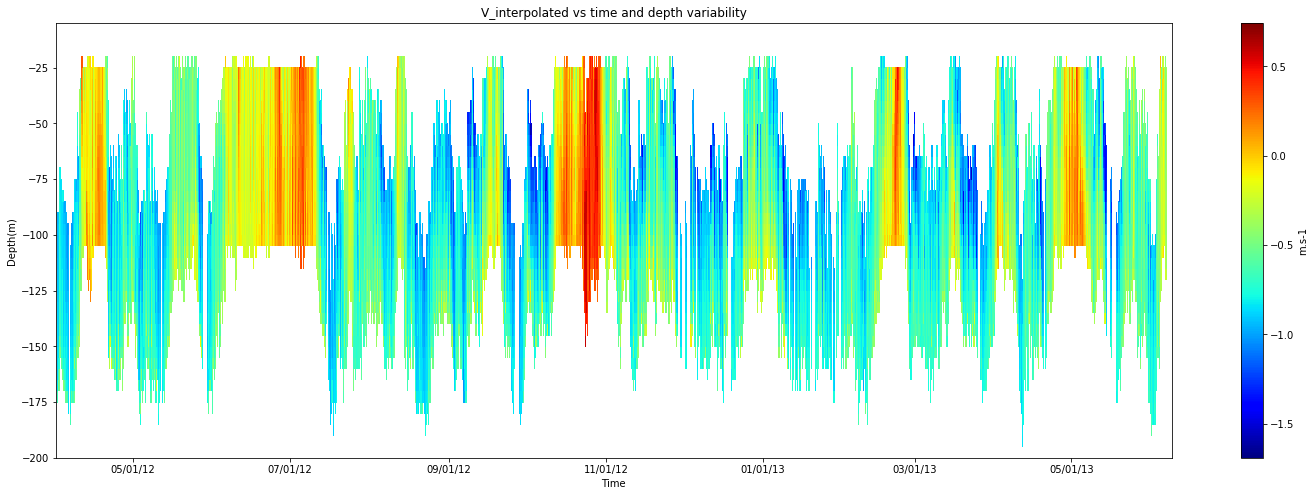

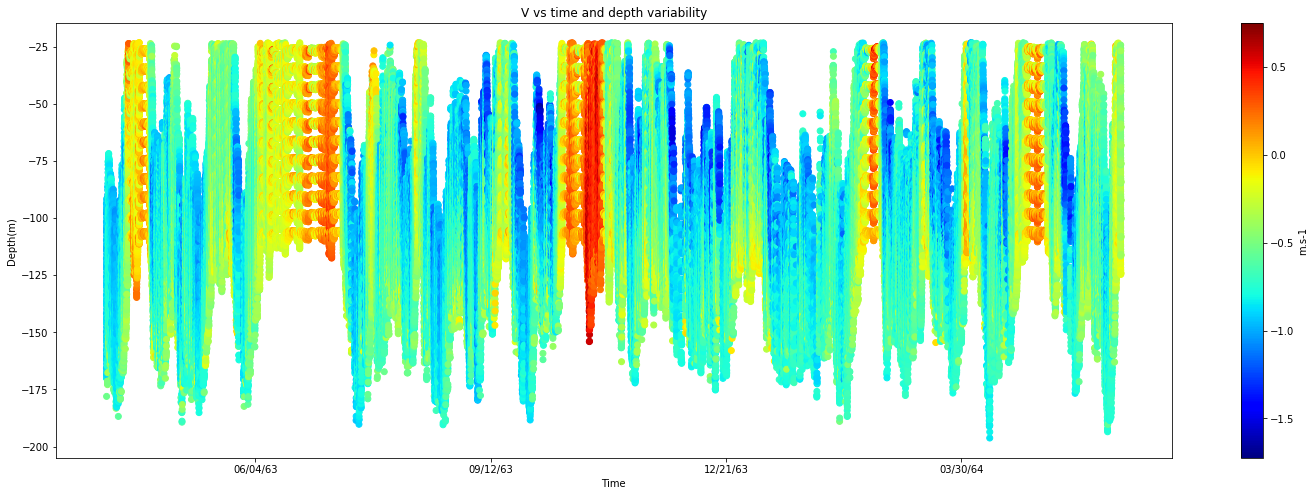

In [12]:

fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.pcolor(times,-Depth_interp_final,np.transpose(V_interp_final_ma),cmap='jet')
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("V_interpolated vs time and depth variability")
clb = plt.colorbar()
clb.set_label('m.s-1')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.scatter(Times_final, -DepthReal, c=Vqc2, cmap='jet')
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("V vs time and depth variability")
clb = plt.colorbar()
clb.set_label('m.s-1')
plt.show()

In [13]:
# For u

In [14]:
# block 9: Use loop "for", for interpolat the new velocity variables with the new depth grid                              

#create the new variable Depth and V for assigned the result of the loop
Depth_interp_final = (np.arange(Depth_f,Depth_i,-Depth_dz))                               # New depth grid
U_interp_final = np.NaN + np.zeros((len(times1),len(Depth_interp_final)))
# OR IF USE APPEND: V_interp_final = [np.empty((len(Depth_interp_final)))]

# Start the loop
# Use vector for time t
for t in range(len(Times_final)):  
#    print('t=' + str(t))
    to_Uqc2_interp = np.NaN + np.zeros(len(Depth_interp_final))
    U_for_loop  = np.NaN + np.zeros(len(depth_Bin))
    Depth_For_loop  = np.NaN + np.zeros(len(depth_Bin))
    U_for_loop = Uqc2[t,:]
    Depth_For_loop = DepthReal[t,:]

#create the good shape for the final depth, use the loop for variables with not only Nan values.
#    print(Depth_interp_final)
    ind, = np.where(~np.isnan(U_for_loop))    
    if ~np.isnan(U_for_loop).all():
        to_Uqc2_interp = np.interp(-Depth_interp_final,-Depth_For_loop[ind],U_for_loop[ind],left=np.NaN,right=np.NaN)
    U_interp_final[t,] = to_Uqc2_interp
# OR IF USE APPEND:     V_interp_final = np.append(V_interp_final, [to_Vqc2_interp], axis=0)

# Mask to be able to plot:
U_interp_final_ma = np.ma.array (U_interp_final, mask=np.isnan(U_interp_final))

# Check
#plt.figure(figsize=(15,10))
#for t in range(0,len(Times_final),100):  
    #U_for_loop = Uqc2[t,:]
    #Depth_For_loop = DepthReal[t,:]
    #plt.plot(U_for_loop,Depth_For_loop,'ko-')
    #plt.plot(U_interp_final[t,:],Depth_interp_final,'bo-')


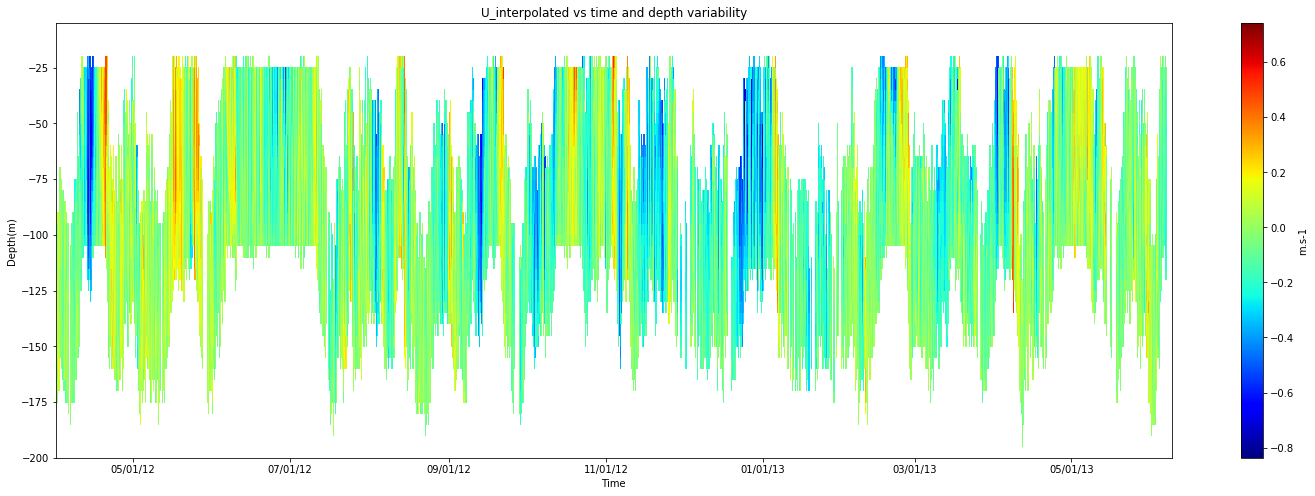

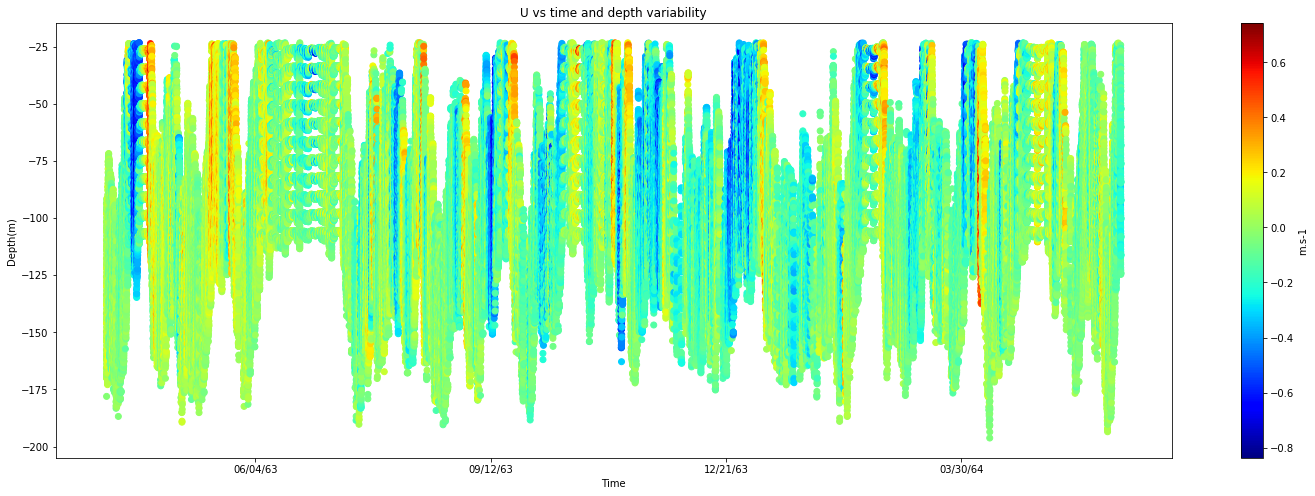

In [15]:
fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.pcolor(times,-Depth_interp_final,np.transpose(U_interp_final_ma),cmap='jet')
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("U_interpolated vs time and depth variability")
clb = plt.colorbar()
clb.set_label('m.s-1')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.scatter(Times_final, -DepthReal, c=Uqc2, cmap='jet')
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
clb = plt.colorbar()
clb.set_label('m.s-1')
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("U vs time and depth variability")
plt.show()

In [16]:
#For Speed

In [17]:
Speed = (Uqc2*Uqc2) + (Vqc2*Vqc2)
Speedf = np.sqrt(Speed)

In [18]:
#rename U and V variables for the speed equation

U_interp_sp = np.transpose(U_interp_final_ma)
V_interp_sp = np.transpose(V_interp_final_ma)

In [19]:
#creat Speed variable

Speed_interp = (U_interp_sp*U_interp_sp) + (V_interp_sp*V_interp_sp)
Speed_interp_final = np.sqrt(Speed_interp)

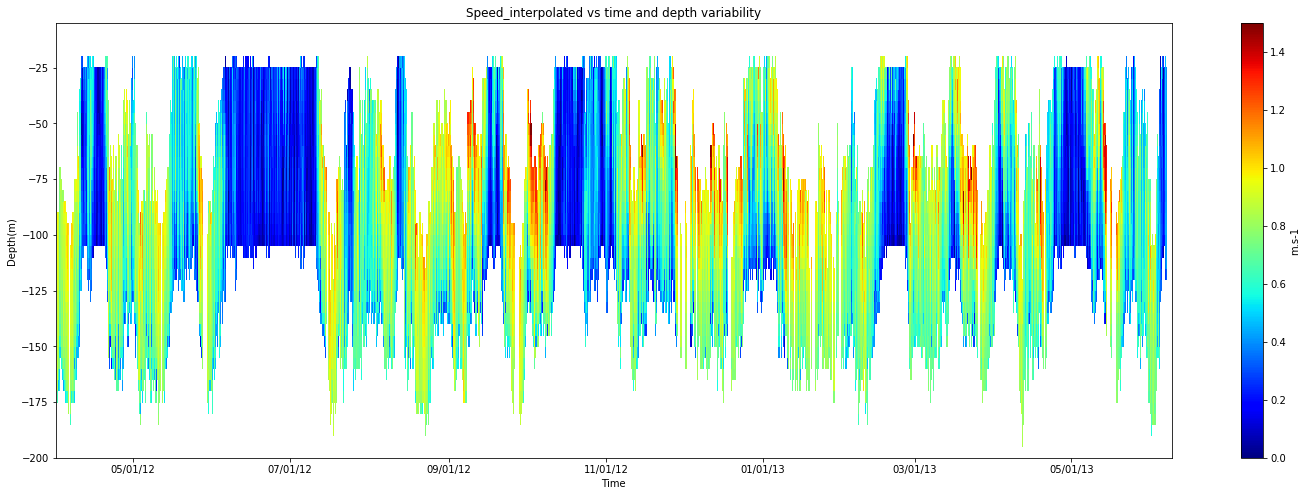

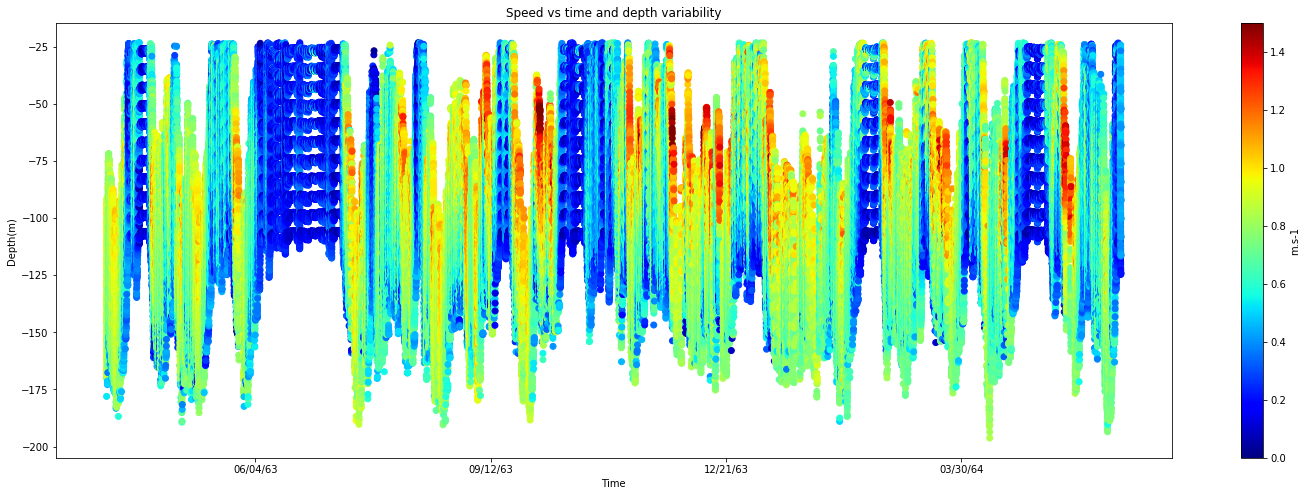

In [20]:
fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.pcolor(times,-Depth_interp_final,Speed_interp_final,cmap='jet',vmin=0,vmax=1.5)
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("Speed_interpolated vs time and depth variability")
clb = plt.colorbar()
clb.set_label('m.s-1')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.scatter(Times_final, -DepthReal, c=Speedf, cmap='jet',vmin=0,vmax=1.5)
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
clb = plt.colorbar()
clb.set_label('m.s-1')
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("Speed vs time and depth variability")
plt.show()

In [21]:
#For Power 

In [22]:
P = 0.5 * 1025* (Speedf*Speedf*Speedf)     
Pf = P/1000

In [23]:
Power_interpolation = 0.5 * 1025* (Speed_interp_final*Speed_interp_final*Speed_interp_final)     
Power_interplation_final = Power_interpolation/1000

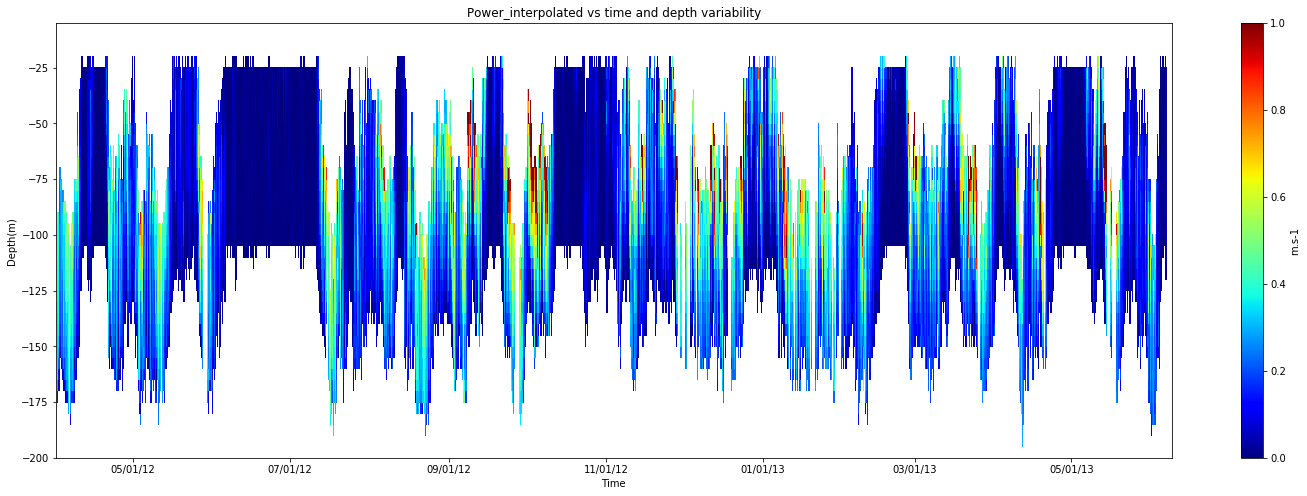

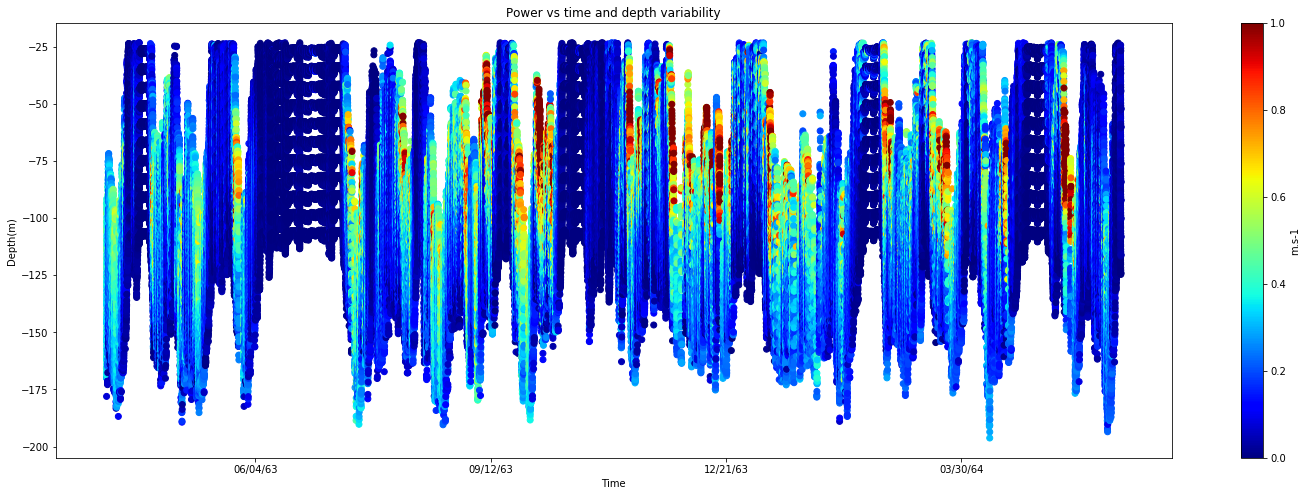

In [24]:
fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.pcolor(times,-Depth_interp_final,Power_interplation_final,cmap='jet',vmin=0,vmax=1)
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("Power_interpolated vs time and depth variability")
clb = plt.colorbar()
clb.set_label('m.s-1')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.scatter(Times_final, -DepthReal, c=Pf, cmap='jet',vmin=0,vmax=1)
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
clb = plt.colorbar()
clb.set_label('m.s-1')
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("Power vs time and depth variability")
plt.show()

In [25]:
#Statistic at 50m depth
#Power_interpolate

In [26]:
np.shape(times),np.shape(-Depth_interp_final),np.shape(Power_interplation_final),np.shape(Speed_interp_final)

((20833,), (40,), (40, 20833), (40, 20833))

In [27]:
-Depth_interp_final[30,]

-50

In [28]:
np.mean(Power_interplation_final[25,:])

0.17774681539748924

In [29]:
Power501 = np.where(Power_interplation_final[20,:]>0.5)
np.shape(Power501)
Power50_final = (5060*100)/20832
Power50_final

24.289554531490015

In [30]:
#Speed

In [31]:
np.mean(Speed_interp_final[30,:])

0.4642450790256878

In [32]:
Speed50 = np.where(Speed_interp_final[30,:] > 1.0)
np.shape(Speed50)
Speed50_final = (235*100)/20833
Speed50_final 

1.1280180482887727

In [33]:
#pourcentage

In [34]:
P_pourcentage_final = []

Depth_i_test = 20                              
Depth_f_test = 195                              
Depth_dz_test = 5
Depth_interp_final_test = (np.arange(Depth_f_test,Depth_i_test,-Depth_dz_test))                               

for t in range(len(Depth_interp_final_test)): 
        Depth_Pourcentage = np.where(Power_interplation_final[t,:] > 0.5)         
        Depth_Pourcentage2 = np.array(Depth_Pourcentage)
        print(np.shape(Depth_Pourcentage2.T))
        P_pourcentage = (len(Depth_Pourcentage2.T)*100)/20833
        print(P_pourcentage)
        
        P_pourcentage_final.append(P_pourcentage)

(20833, 1)
100.0
(20832, 1)
99.99519992319877
(20821, 1)
99.94239907838525
(20772, 1)
99.70719531512505
(20592, 1)
98.84318149090386
(20271, 1)
97.3023568377094
(19784, 1)
94.96471943551097
(19147, 1)
91.9070705131282
(18313, 1)
87.90380646090337
(17298, 1)
83.03172850765613
(16087, 1)
77.21883550136802
(14793, 1)
71.00753612057792
(13532, 1)
64.95463927422838
(12302, 1)
59.05054480871694
(11112, 1)
53.33845341525464
(10195, 1)
48.93678298852782
(9278, 1)
44.535112561800986
(8545, 1)
41.01665626650026
(7635, 1)
36.64858637738204
(4546, 1)
21.821149138386215
(5060, 1)
24.288388614217826
(5533, 1)
26.55882494119906
(6224, 1)
29.875678010848173
(7034, 1)
33.76374021984352
(7997, 1)
38.38621417942687
(8882, 1)
42.63428214851437
(9656, 1)
46.34954159266548
(10364, 1)
49.74799596793549
(10971, 1)
52.66164258628138
(11489, 1)
55.14808236931791
(12041, 1)
57.797724763596214
(12685, 1)
60.888974223587574
(13332, 1)
63.99462391398262
(14112, 1)
67.7386838189411
(15337, 1)
73.6187779004464


In [35]:
#20833*35
#20833+20832+20821+20772+20592+20271+19784+19147+18313+17298+16087+14798+13532+12302+11112+10195+9278+8545+7635+4546+5060+5533+6224+7034+7997+8882+9656+10364+10971+11489+12041+12685+13332+14112+15337  
(457410*100)/729155

62.731517990002125

In [36]:
Power_interplation_final,np.shape(P_pourcentage_final)

(masked_array(
   data=[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],
   mask=[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],
   fill_value=1e+20), (35,))

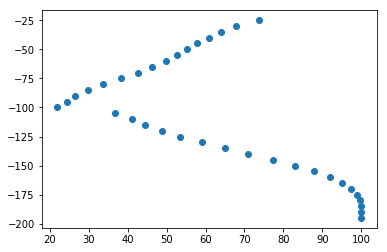

In [37]:
plt.plot(P_pourcentage_final,-Depth_interp_final_test, 'o')
#plt.ylim(-110,-25)

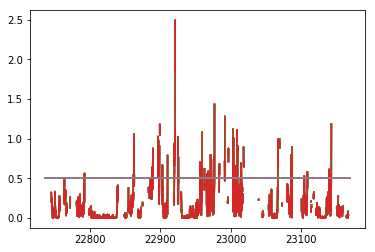

In [38]:
pp = Power_interplation_final[29,:]
test = [0.5]
test2=np.kron(np.ones((20833,1)),test)
plt.plot(Times_final,pp.T)
plt.plot(Times_final,test2)

In [39]:
np.shape(Power_interplation_final)

(40, 20833)

In [40]:
np.shape(-Depth_interp_final)

(40,)

In [41]:
-Depth_interp_final[36,]

-20